# ACT2023 Tutorial Sessions - exercises part 2 
init draft: 05 Aug 2023
last update: 07 Aug 2023

Ref: \
https://act2023tutorials.netlify.app/algebraicjulia/exercises \
https://act2023tutorials.netlify.app/algebraicjulia/solutions

## Exercise (Growing rabbits)

In [1]:
using AlgebraicDynamics

ṙ(r,p,t) = p.α * r
rabbit_growth = ContinuousResourceSharer{Float64}(1, ṙ)

ContinuousResourceSharer(ℝ^1 → ℝ^1) with 1 exposed port

In [2]:
# import Pkg; Pkg.add("LabelledArrays")
# import Pkg; Pkg.add("DifferentialEquations")

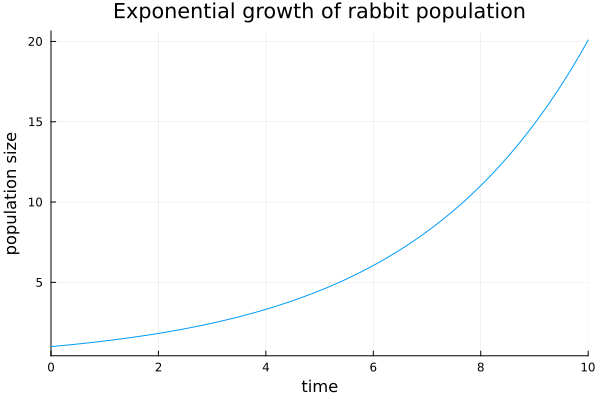

In [3]:
using LabelledArrays
using DifferentialEquations, Plots

u0 = [1.0]
params = LVector(α=0.3)
tspan = (0.0, 10.0)

prob = ODEProblem(rabbit_growth, u0, tspan, params)
sol = solve(prob, Tsit5())

plot(sol, title="Exponential growth of rabbit population",
     legend=false, xlabel="time", ylabel="population size")

## Exercise (UWDs as data structure)
UWD: undirected wiring diagrams

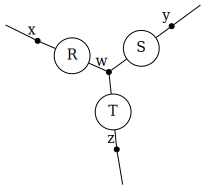

In [14]:
using Catlab

uwd = @relation (x,y,z) where (w,x,y,z) begin
  R(x,w)
  S(y,w)
  T(z,w)
end

to_graphviz(uwd, box_labels=:name, junction_labels=:variable)

In [17]:
using Test

d = RelationDiagram(3) # Create diagram with 3 outer ports
add_junctions!(d, 4, variable=[:w,:x,:y,:z]) # Add four junctions
set_junction!(d, 1:3, 2:4, outer=true) # Set junctions of outer ports

for name in [:R, :S, :T]
  add_box!(d, 2, name=name) # Add box with two ports
end
for (i, box) in enumerate(boxes(d))
  set_junction!(d, (box, 1), i+1)
  set_junction!(d, (box, 2), 1)
end

@test d == uwd

Test Passed

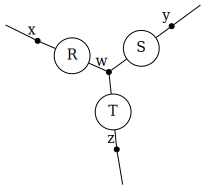

In [19]:
to_graphviz(d, box_labels=:name, junction_labels=:variable)

## Exercise (Pendulum)

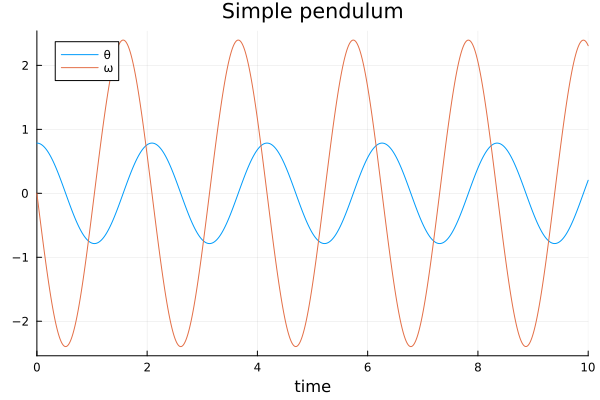

In [20]:
du(u,p,t) = [u[2], -p.g/p.ℓ * sin(u[1])]

pendulum = ContinuousResourceSharer{Float64}(2, du)

u0 = [π/4, 0]
params = LVector(g=9.8, ℓ=1)
tspan = (0.0, 10.0)

prob = ODEProblem(pendulum, u0, tspan, params)
sol = solve(prob, Tsit5())
plot(sol, title="Simple pendulum", xlabel="time", label=["θ" "ω"])

## Exercise (Graph traversal)

In [22]:
# import Pkg; Pkg.add("DataStructures")

   Resolving package versions...
    Updating `~/.julia/environments/v1.9/Project.toml`
  [864edb3b] + DataStructures v0.18.15
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


In [23]:
using Catlab
using DataStructures: Stack

""" Depth-first search in graph `g` starting at vertex `v`

The function `f` is called at every vertex in the search path.
"""
function dfs(f::Function, g::ACSet, v::Int)
  seen = Set{Int}()
  next = Stack{Int}()
  push!(next, v)
  while !isempty(next)
    v = pop!(next)
    v ∈ seen && continue
    f(v)
    push!(seen, v)
    # Add all outgoing edges to the stack.
    for e in incident(g, v, :src)
      # Syntactic sugar: `g[e, :tgt] == subpart(g, e, :tgt)``
      push!(next, g[e, :tgt])
    end
  end
end

dfs

In [24]:
g = cycle_graph(Graph, 6)
dfs(println, g, 3)

3
4
5
6
1
2


## Exercise (Union-find)

In [28]:
using Catlab
using DataStructures: IntDisjointSets, union!, find_root

import Catlab.Graphs.GraphAlgorithms.connected_components

""" Find connected components of a graph.

Returns a dictionary from the component roots to lists of vertices in each
component.
"""
function connected_components(g::HasGraph)
  sets = IntDisjointSets(nparts(g, :V))
  for e in parts(g, :E)
    union!(sets, g[e,:src], g[e,:tgt])
  end

  components = Dict{Int,Vector{Int}}()
  for v in parts(g, :V)
    # The first argument inserts an empty array
    # when v's connected component has not yet been visited.
    component = get!(() -> Int[], components, find_root(sets, v))
    push!(component, v)
  end
  components
end

Catlab.Graphs.GraphAlgorithms.connected_components

In [29]:
g = path_graph(Graph, 3) ⊕ cycle_graph(Graph, 4) ⊕ star_graph(Graph, 4)

values(connected_components(g))

ValueIterator for a Dict{Int64, Vector{Int64}} with 3 entries. Values:
  [4, 5, 6, 7]
  [8, 9, 10, 11]
  [1, 2, 3]

## Exercise (Julia macros)

In [30]:
macro make_graph(expr)
  make_graph(expr)
end

function make_graph(block::Expr)
  g = Graph()
  vnames = Dict{Symbol,Int}()
  block.head == :block || error("Input to `make_graph` must be a block")
  for arg in block.args
    if arg isa LineNumberNode
      continue
    elseif arg isa Symbol
      haskey(vnames, arg) && error("Vertex $arg already defined")
      vnames[arg] = add_vertex!(g)
    elseif arg isa Expr && arg.head == :(->)
      sname, rhs = arg.args
      tname = rhs.args[2]
      add_edge!(g, vnames[sname], vnames[tname])
    else
      error("Cannot parse statement $arg")
    end
  end
  g
end

make_graph (generic function with 1 method)

In [31]:
g = @make_graph begin
  a
  b
  c
  a -> b
  b -> c
end

to_graphviz(g)